<a href="https://colab.research.google.com/github/meng-86/Project-4/blob/main/Stroke_model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
spark_version = 'spark-3.2.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()
import pandas as pd

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
The system cannot find the path specified.
'wget' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open '$SPARK_VERSION-bin-hadoop2.7.tgz'


Exception: Unable to find py4j in /content/spark-3.2.1-bin-hadoop2.7\python, your SPARK_HOME may not be configured correctly

In [ ]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [ ]:
from pyspark import SparkFiles
url ="https://project-4.s3.eu-west-2.amazonaws.com/stroke-dataset.csv"
spark.sparkContext.addFile(url)
stroke_data = spark.read.csv(SparkFiles.get("stroke-dataset.csv"), header=True, inferSchema=True)

stroke_data.show(10)

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
stroke_df = stroke_data.toPandas()
stroke_df.head()

In [ ]:
stroke_df = stroke_df.drop('id', 1)

In [ ]:
stroke_df

### Machine learning modelling 

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import ensemble
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from IPython.core.display import HTML 

### Visualisation

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

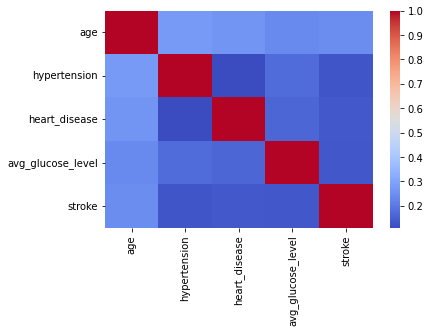

In [13]:
sns.heatmap(abs(stroke_df.corr()), cmap="coolwarm")
plt.savefig('pearsons.png', bbox_inches='tight')

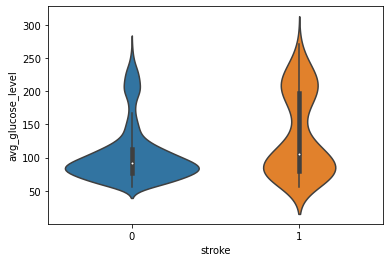

In [15]:
sns.violinplot(x=stroke_df["stroke"], y=stroke_df["avg_glucose_level"], data=stroke_df)

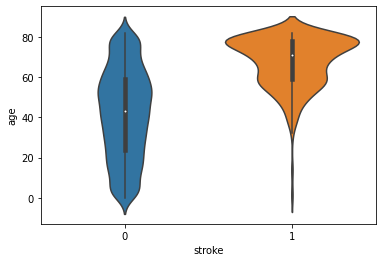

In [16]:
sns.violinplot(x=stroke_df["stroke"], y=stroke_df["age"], data=stroke_df)

### Data analysis

In [20]:
stroke_df.drop(stroke_df[stroke_df["smoking_status"] == "Unknown"].index, inplace=True)  # Observations decreased from 5110 to 3566
stroke_df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes'], dtype=object)

In [21]:
stroke_df.drop(stroke_df[stroke_df["gender"] == "Other"].index, inplace=True)  # Observations decreased from 3566 to 3565
stroke_df['gender'].unique()

array(['Male', 'Female'], dtype=object)

In [22]:
print(stroke_df.isnull().sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [63]:
stroke_df = stroke_df.fillna(np.mean(stroke_df['bmi']))
print(stroke_df.isnull().sum())

TypeError: ignored

In [27]:
df = pd.get_dummies(stroke_df, columns=['work_type', 'smoking_status'], prefix=['work', 'smoke'])
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children,smoke_formerly smoked,smoke_never smoked,smoke_smokes
0,Male,67.0,0,1,Yes,Urban,228.69,36.6,1,0,0,1,0,0,1,0,0
1,Female,61.0,0,0,Yes,Rural,202.21,N/A,1,0,0,0,1,0,0,1,0
2,Male,80.0,0,1,Yes,Rural,105.92,32.5,1,0,0,1,0,0,0,1,0
3,Female,49.0,0,0,Yes,Urban,171.23,34.4,1,0,0,1,0,0,0,0,1
4,Female,79.0,1,0,Yes,Rural,174.12,24,1,0,0,0,1,0,0,1,0


In [28]:
df['ever_married'] = np.where(df['ever_married'] == 'Yes', 1, 0)
df['gender'] = np.where(df['gender'] == 'Male', 1, 0)
df['Residence_type'] = np.where(df['Residence_type'] == 'Urban', 1, 0)
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children,smoke_formerly smoked,smoke_never smoked,smoke_smokes
0,1,67.0,0,1,1,1,228.69,36.6,1,0,0,1,0,0,1,0,0
1,0,61.0,0,0,1,0,202.21,N/A,1,0,0,0,1,0,0,1,0
2,1,80.0,0,1,1,0,105.92,32.5,1,0,0,1,0,0,0,1,0
3,0,49.0,0,0,1,1,171.23,34.4,1,0,0,1,0,0,0,0,1
4,0,79.0,1,0,1,0,174.12,24,1,0,0,0,1,0,0,1,0


### Machine learning modelling

In [29]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from imblearn.over_sampling import SMOTE

In [30]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(est, X_train, y_train) :
    train_sizes, train_scores, test_scores = learning_curve(estimator=est, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=5,
                                                        n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(8,10))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
    plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
    plt.grid(b='on')
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.6, 1.0])
    plt.title('%s'%est) 
    plt.show()

In [32]:
def plot_roc_curve(est,X_test,y_test) :
    probas = est.predict_proba(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,probas[:, 1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.figure(figsize=(8,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')        
    plt.plot([0,0,1],[0,1,1],'g:')     # plus mauvaise courbe
    plt.xlim([-0.05,1.2])
    plt.ylim([-0.05,1.2])
    plt.ylabel('Taux de vrais positifs')
    plt.xlabel('Taux de faux positifs')
    plt.show

In [62]:
X = df.drop(['stroke'],axis=1)
y = df['stroke']
sm = SMOTE(random_state=2)
X, y = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


ValueError: ignored

In [34]:
# Logistic Regression
logit = LogisticRegression()
logit.fit(X_train, y_train)
logit.pred = logit.predict(X_test)
logit_accuracy = accuracy_score(logit.pred, y_test)
print('Accuracy:', logit_accuracy)
precision = precision_score(y_test, logit.pred)
print('Precision:', precision)
print(classification_report(y_test, logit.pred))

NameError: ignored

In [54]:
plot_learning_curve(logit, X_train, y_train)

NameError: ignored

In [55]:
# Random Forest
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
RF.pred = RF.predict(X_test)
RF_accuracy = accuracy_score(RF.pred, y_test)
print('Accuracy:', RF_accuracy)
precision = precision_score(y_test, RF.pred)
print('Precision:', precision)
print(classification_report(y_test, RF.pred))

NameError: ignored

In [56]:
plot_learning_curve(RF, X_train, y_train)

NameError: ignored

In [57]:
# ExtraTrees
ET = ExtraTreesClassifier()
ET.fit(X_train, y_train)
ET.pred = ET.predict(X_test)
ET_accuracy = accuracy_score(ET.pred, y_test)
print('Accuracy:', ET_accuracy)
precision = precision_score(y_test, ET.pred)
print('Precision:', precision)
print(classification_report(y_test, ET.pred))

NameError: ignored

In [58]:
plot_learning_curve(ET, X_train, y_train)

NameError: ignored

In [59]:
# Gradient Boosting
GB = GradientBoostingClassifier()
GB.fit(X_train, y_train)
GB.pred = GB.predict(X_test)
GB_accuracy = accuracy_score(GB.pred, y_test)
print('Accuracy:', GB_accuracy)
precision = precision_score(y_test, GB.pred)
print('Precision:', precision)
print(classification_report(y_test, GB.pred))

NameError: ignored

In [60]:
plot_learning_curve(GB, X_train, y_train)

NameError: ignored